In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRFRegressor, XGBClassifier



from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score,  recall_score, f1_score, fbeta_score



from sklearn.model_selection import GridSearchCV



import joblib



import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("D:\\Courses\\Datasets\\healthcare_dataset.csv")
data.head(5)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.28131,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.32729,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.09608,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.78241,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.31781,458,Urgent,2022-10-09,Penicillin,Abnormal


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

# Billing Amount Prediction (Regression)
## Data Preprocessing
* Drop non-informative columns (Name, Room Number)
* Convert date columns to datetime
* Extract useful features (as hospital stay duration)
* Encode categorical variables
* Scale numerical variables

In [4]:
df = data.copy()
print(df.columns)
print(f'Number of Features: {len(df.columns)}')

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')
Number of Features: 15


In [5]:
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
print(df.columns)
print(f'Number of Features: {len(df.columns)}')

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results', 'Length of Stay'],
      dtype='object')
Number of Features: 16


In [6]:
df = df.drop(columns=['Name', 'Doctor', 'Hospital', 'Room Number', 'Date of Admission', 'Discharge Date'])
print(f'Number of Features: {len(df.columns)}')

Number of Features: 10


### Check Missing data

In [7]:
df.isnull().sum()

Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Insurance Provider    0
Billing Amount        0
Admission Type        0
Medication            0
Test Results          0
Length of Stay        0
dtype: int64

### Detect and Handle Outliers

<Axes: xlabel='Billing Amount'>

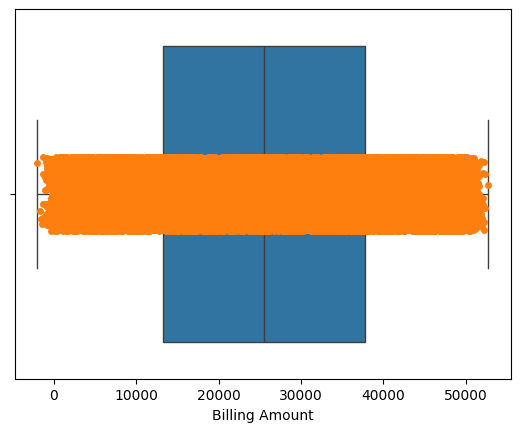

In [8]:
sns.boxplot(data=df, x='Billing Amount')
sns.stripplot(data=df, x='Billing Amount')

### Pipelines

In [9]:
x = df.drop(columns=['Billing Amount'])
y = df['Billing Amount']

In [10]:
categorical_cols = x.select_dtypes(include=['object']).columns.tolist()
numerical_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Split data to Train and Test Sets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Modeling

In [13]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    'KNN' : KNeighborsRegressor(),
    'Decision Tree' : DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGB' : XGBRFRegressor(),
    'SVM' : SVR()
}

In [19]:
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse,"MAE": mae,"R2": r2}

results_df = pd.DataFrame(results).T.sort_values("RMSE", ascending=True)
print(results_df)

                           RMSE           MAE        R2
Random Forest      13801.631059  11691.039619  0.042353
SVM                14104.292390  12187.749630 -0.000109
XGB                14108.110204  12191.747858 -0.000650
Lasso Regression   14110.881449  12192.205636 -0.001044
Ridge Regression   14110.903416  12192.218856 -0.001047
Linear Regression  14110.904420  12192.218991 -0.001047
Gradient Boosting  14121.054403  12201.163657 -0.002487
KNN                15190.215624  12759.744435 -0.160039
Decision Tree      19370.920651  15099.926887 -0.886450


In [34]:
best_model_name = results_df.index[0]
best_model = models[best_model_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', best_model)])

## Models Evaluated
### We trained and evaluated the following regression models:
* Linear Regression
* Ridge Regression
* Lasso Regression
* K Nearest Neighbors
* Decision Tree
* Random Forest Regressor
* Gradient Boosting
* XGB
* Support Vector Machine
### Best model: Random Forest Regressor –> lowest RMSE and highest R² score.

### Hyperparameter tuning for the best model

In [36]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}


pipeline = Pipeline(steps=[('preprocessor', preprocessor),('regressor', best_model)])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Length '
                                                                          'of '
                                                                          'Stay']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Blood '
                                                                          'Type',
                                                                          'Medical '
                                                                          'Condition',
                                                                          'Insurance '
                                                                          'Provider',
                                                                          'Admission '
                                                                          'Type',
                                                                          'Medication',
                                                                          'Test '
                                                                          'Results'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error')

In [21]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test)

In [22]:
rmse = mean_squared_error(y_test, y_pred_best, squared=False)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)
print("Best Parameters:", grid_search.best_params_)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 13623.40, MAE: 11446.16, R²: 0.07
